In [1]:
# ===================================================================
# SETUP CELL
# Ensures 'dataset' and 'label_names' are defined in memory.
# ===================================================================
from datasets import load_dataset
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')


# 1. Load the dataset from your local files
print("Step 1/2: Loading dataset...")
dataset = load_dataset("json", data_files={
    "train": "finer-139/train.jsonl",
    "validation": "finer-139/validation.jsonl",
    "test": "finer-139/test.jsonl"
})
print("-> Dataset loaded successfully.")


# 2. Dynamically discover all unique labels from your specific dataset
print("\nStep 2/2: Discovering unique labels...")
unique_ner_tags = set()
for split in dataset:
    for example in tqdm(dataset[split], desc=f"Scanning {split}"):
        unique_ner_tags.update(example['ner_tags'])

sorted_labels = sorted(list(unique_ner_tags))
if "O" in sorted_labels:
    sorted_labels.remove("O")
    label_names = ["O"] + sorted_labels
else:
    label_names = sorted_labels
print(f"-> Found {len(label_names)} unique labels.")
print("\n✅ Setup complete. Ready for EDA.")

Step 1/2: Loading dataset...
-> Dataset loaded successfully.

Step 2/2: Discovering unique labels...


Scanning train:   0%|          | 0/900384 [00:00<?, ?it/s]

Scanning validation:   0%|          | 0/112494 [00:00<?, ?it/s]

Scanning test:   0%|          | 0/108378 [00:00<?, ?it/s]

-> Found 170 unique labels.

✅ Setup complete. Ready for EDA.


In [ ]:
# EDA FUNCTIONS DEFINITION CELL
# Defines all the functions needed for the analysis.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")

def analyze_dataset_overview(dataset):
    """Analyze basic dataset statistics"""
    print("📊 DATASET OVERVIEW")
    print("=" * 50)
    for split_name in dataset.keys():
        split_data = dataset[split_name]
        print(f"{split_name.upper()} Split: - Number of samples: {len(split_data):,}")
    print("\n📋 SAMPLE DATA INSPECTION (from train split)")
    sample = dataset['train'][0]
    print(f"First 10 tokens: {sample['tokens'][:10]}")
    print(f"First 10 NER tags: {sample['ner_tags'][:10]}")

def analyze_sequence_lengths(dataset):
    """Analyze token sequences and their lengths"""
    print("\n📏 SEQUENCE LENGTH ANALYSIS")
    print("=" * 50)
    all_lengths = []
    for split_name in dataset.keys():
        lengths = [len(example['tokens']) for example in dataset[split_name]]
        all_lengths.extend(lengths)
        print(f"{split_name.upper()} Split - Max length: {np.max(lengths):,}, Mean length: {np.mean(lengths):.2f}")
    
    plt.figure(figsize=(12, 6))
    sns.histplot(all_lengths, bins=50, kde=True)
    plt.title('Distribution of All Document Lengths (Number of Tokens)')
    plt.xlabel('Number of Tokens')
    plt.ylabel('Frequency')
    plt.show()

def analyze_ner_tags(dataset, label_names):
    """Analyze NER tag distributions"""
    print("\n🏷️ NER TAG DISTRIBUTION ANALYSIS")
    print("=" * 50)
    all_tags = []
    for split_name in dataset.keys():
        for example in dataset[split_name]:
            tags = example['ner_tags']
            if not tags: continue
            if isinstance(tags[0], str):
                all_tags.extend(tags)
            else: # If tags are integers, convert them to names
                all_tags.extend([label_names[tag] for tag in tags])
    
    total_tag_counts = Counter(all_tags)
    entity_types = defaultdict(int)
    for tag, count in total_tag_counts.items():
        if tag.startswith('B-'):
            entity_types[tag[2:]] += count
            
    print(f"Total unique NER tags found: {len(total_tag_counts)}")
    print(f"\nTop 15 most frequent NER tags:")
    for tag, count in total_tag_counts.most_common(15):
        print(f"  {tag}: {count:,}")
        
    return total_tag_counts, entity_types

def visualize_tag_distributions(total_tag_counts, entity_types):
    """Create visualizations for tag distributions"""
    print("\n📈 TAG DISTRIBUTION VISUALIZATIONS")
    print("=" * 50)
    
    # 1. O vs Non-O tag distribution
    o_count = total_tag_counts.get('O', 0)
    non_o_count = sum(count for tag, count in total_tag_counts.items() if tag != 'O')
    
    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    plt.pie([o_count, non_o_count], labels=['O (Outside)', 'Named Entities'], autopct='%1.1f%%', startangle=140)
    plt.title('Proportion of "O" Tags vs. Entity Tags')

    # 2. Top 15 entity types (B- tags only)
    top_entities = dict(sorted(entity_types.items(), key=lambda x: x[1], reverse=True)[:15])
    plt.subplot(1, 2, 2)
    sns.barplot(x=list(top_entities.values()), y=list(top_entities.keys()))
    plt.title('Top 15 Entity Types by Frequency')
    plt.xlabel('Frequency (Count of B- tags)')
    plt.ylabel('Entity Type')
    
    plt.tight_layout()
    plt.show()

def perform_data_quality_checks(dataset):
    """Perform basic data quality checks"""
    print("\n🔍 DATA QUALITY CHECKS")
    print("=" * 50)
    for split_name in dataset.keys():
        mismatched_lengths = 0
        for i, example in enumerate(dataset[split_name]):
            if len(example['tokens']) != len(example['ner_tags']):
                mismatched_lengths += 1
        print(f"{split_name.upper()} Split - Mismatched token/tag lengths: {mismatched_lengths}")

def run_complete_eda(dataset, label_names):
    """Run complete EDA analysis"""
    analyze_dataset_overview(dataset)
    analyze_sequence_lengths(dataset)
    total_tag_counts, entity_types = analyze_ner_tags(dataset, label_names)
    visualize_tag_distributions(total_tag_counts, entity_types)
    perform_data_quality_checks(dataset)
    print("\n" + "="*50 + "\n🎉 EDA ANALYSIS COMPLETE!\n" + "="*50)
    return {'tag_counts': total_tag_counts, 'entity_types': entity_types}

print("✅ All EDA functions are now defined.")

✅ All EDA functions are now defined.


📊 DATASET OVERVIEW
TRAIN Split: - Number of samples: 900,384
VALIDATION Split: - Number of samples: 112,494
TEST Split: - Number of samples: 108,378

📋 SAMPLE DATA INSPECTION (from train split)
First 10 tokens: ['ITEM', '1', 'Financial', 'Statements', 'Lennar', 'Corporation', 'and', 'Subsidiaries', 'Condensed', 'Consolidated']
First 10 NER tags: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']

📏 SEQUENCE LENGTH ANALYSIS
TRAIN Split - Max length: 1,260, Mean length: 45.34
VALIDATION Split - Max length: 1,157, Mean length: 46.17
TEST Split - Max length: 1,193, Mean length: 47.24


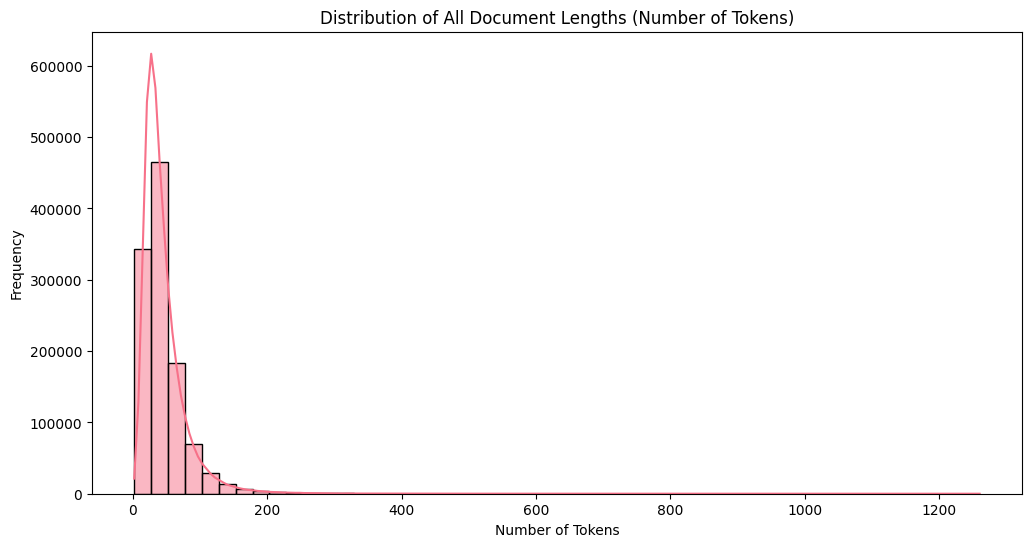


🏷️ NER TAG DISTRIBUTION ANALYSIS
Total unique NER tags found: 170

Top 15 most frequent NER tags:
  O: 50,755,070
  B-DebtInstrumentInterestRateStatedPercentage: 18,448
  B-LineOfCreditFacilityMaximumBorrowingCapacity: 14,730
  B-DebtInstrumentBasisSpreadOnVariableRate1: 14,469
  B-DebtInstrumentFaceAmount: 13,158
  B-AllocatedShareBasedCompensationExpense: 10,160
  B-AntidilutiveSecuritiesExcludedFromComputationOfEarningsPerShareAmount: 9,162
  B-EffectiveIncomeTaxRateContinuingOperations: 8,684
  B-AmortizationOfIntangibleAssets: 7,458
  B-ConcentrationRiskPercentage1: 6,779
  B-ShareBasedCompensationArrangementByShareBasedPaymentAwardEquityInstrumentsOtherThanOptionsGrantsInPeriod: 5,763
  B-IncomeTaxExpenseBenefit: 5,485
  B-EquityMethodInvestmentOwnershipPercentage: 5,473
  I-DebtInstrumentMaturityDate: 5,319
  B-RestructuringCharges: 5,277

📈 TAG DISTRIBUTION VISUALIZATIONS


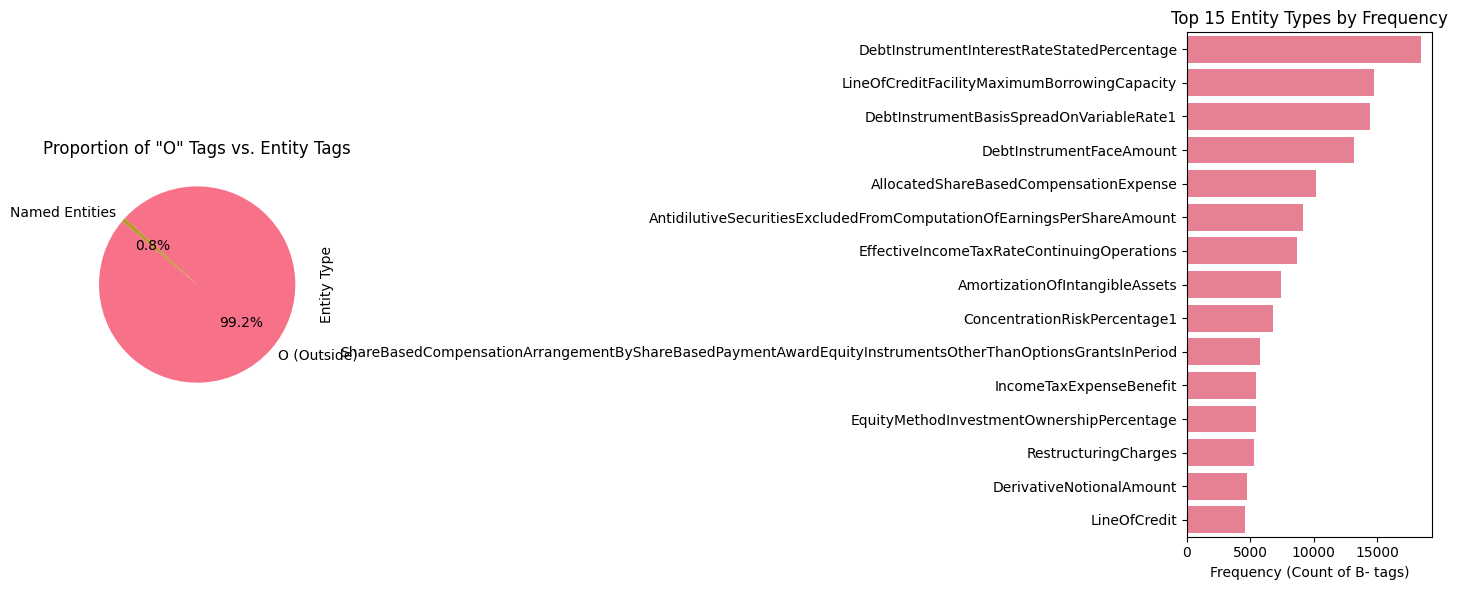


🔍 DATA QUALITY CHECKS
TRAIN Split - Mismatched token/tag lengths: 0
VALIDATION Split - Mismatched token/tag lengths: 0
TEST Split - Mismatched token/tag lengths: 0

🎉 EDA ANALYSIS COMPLETE!


In [3]:
# ===================================================================
# EXECUTION CELL
# Calls the main function to run the analysis and show results.
# ===================================================================

# This one line runs the entire analysis
eda_results = run_complete_eda(dataset, label_names)